In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [88]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [89]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [90]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [91]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [92]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [93]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [94]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[1]]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[1]]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1683,ECS010230100188,010000371218,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-09,40,HC,1500.0
1684,ECS010230100390,010000377561,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1685,ECS010230100390,010000371211,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-14,40,HC,1500.0
1686,ECS010230100462,010000390201,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0
1687,ECS010230100462,010000377408,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-02-21,40,HC,1500.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1688 non-null   object        
 1   CNTR_ID     1688 non-null   object        
 2   POD_ID      1688 non-null   object        
 3   ETD_POL_D   1688 non-null   object        
 4   PARTY_ID    1688 non-null   object        
 5   PARTY_NAME  1688 non-null   object        
 6   POD         1688 non-null   datetime64[ns]
 7   CNTR_SIZE   1688 non-null   object        
 8   CNTR_TYPE   1688 non-null   object        
 9   RATE        1688 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600140,CTNR010050700496,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
1,ECS01050600140,CTNR010050700495,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-19,40,HC,2200.0
2,ECS010050700037,CTNR010050700657,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-21,40,HC,2300.0
3,ECS01050600141,CTNR010050700808,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-26,40,HC,2200.0
4,ECS01050600042,CTNR010050700971,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-29,40,HC,2600.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1699,ECS010230200029,010000495920,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-04-23,40,HC,664.0
1700,ECS010230400101,010000535699,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,350.0
1701,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
1702,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
1703,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 1703
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1704 non-null   object        
 1   CNTR_ID     1704 non-null   object        
 2   POD_ID      1704 non-null   object        
 3   ETD_POL_D   1704 non-null   object        
 4   PARTY_ID    1704 non-null   object        
 5   PARTY_NAME  1704 non-null   object        
 6   POD         1704 non-null   datetime64[ns]
 7   CNTR_SIZE   1704 non-null   object        
 8   CNTR_TYPE   1704 non-null   object        
 9   RATE        1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 146.4+ KB


<h4>Interpolate missing values in between dates</h4>

In [95]:
# Interpolate using spline interpolation

# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(2)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-19,2200.00
1,2005-07-20,2249.99
2,2005-07-21,2300.00
3,2005-07-22,2279.99
4,2005-07-23,2260.01


,POD,RATE
6447,2023-02-17,1500.0
6448,2023-02-18,1500.0
6449,2023-02-19,1500.0
6450,2023-02-20,1500.0
6451,2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6452 entries, 0 to 6451
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6452 non-null   datetime64[ns]
 1   RATE    6452 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.2 KB


<h4>Grouping it to week</h4>

In [96]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19568\1175119283.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19568\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19568\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_19568\1175119283.py:42: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-07-18,2255.001667
1,2005-07-25,2388.568571
2,2005-08-01,2261.425714
3,2005-08-08,2200.000000
4,2005-08-15,2253.570000
5,2005-08-22,2252.142857
6,2005-08-29,2252.450000
7,2005-09-05,2214.290000
8,2005-09-12,2200.000000
9,2005-09-19,2200.000000


,YearMonthWeek,Rate
903,2022-11-07,5145.744286
904,2022-11-14,5877.270000
905,2022-11-21,5404.560000
906,2022-11-28,4232.477143
907,2022-12-05,3433.128571
908,2022-12-12,3580.520000
909,2022-12-19,4012.910000
910,2022-12-26,4166.275714
911,2023-01-02,2800.350000
912,2023-01-09,2687.470000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [97]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200255,010000421246,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
1,ECS010230200255,010000410650,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-10,40,HC,1100.0
2,ECS010230100273,010000423692,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-03-14,40,HC,986.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230300066,010000515298,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-02,40,HC,264.0
14,ECS010230300067,010000550266,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0
15,ECS010230300067,010000535541,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2023-05-08,40,HC,264.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


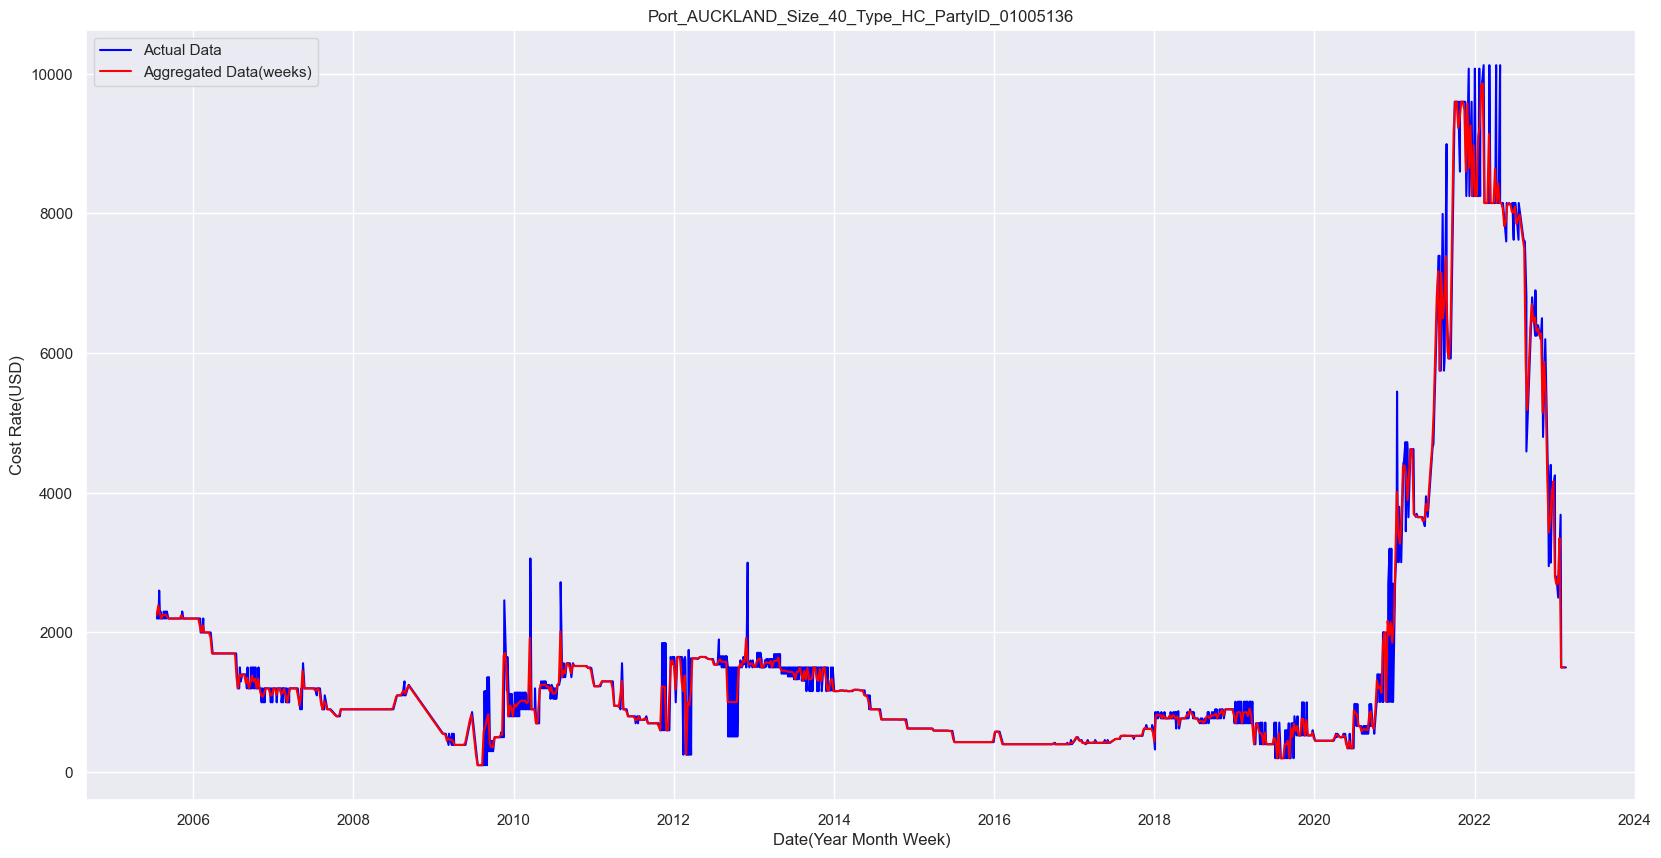

In [98]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(old_df[1])
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [99]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>Remove Outliers</h4>

In [100]:
from scipy import stats

def remove_outliers_z_score(df, column, z_threshold=3):
    df = df[(np.abs(stats.zscore(df[column])) < z_threshold)]
    return df

<h4>ARIMA<h4>

In [101]:
df_arima1 = agg_df[['YearMonthWeek','Rate']].copy()
df_arima1.set_index('YearMonthWeek', inplace=True)
df_arima1.head()
df_arima1.info()

,Rate
YearMonthWeek,
2005-07-18,2255.001667
2005-07-25,2388.568571
2005-08-01,2261.425714
2005-08-08,2200.000000
2005-08-15,2253.570000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 918 entries, 2005-07-18 to 2023-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    918 non-null    float64
dtypes: float64(1)
memory usage: 14.3 KB


In [106]:
import pmdarima as pm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

# Split the data into training, validation, and test sets
train_size = int(len(df_arima1) * 0.7)
val_size = int(len(df_arima1) * 0.2)
train, val, test = df_arima1[:train_size], df_arima1[train_size:train_size+val_size], df_arima1[train_size+val_size:]

# Fit the ARIMA model
arima_model = pm.auto_arima(train, start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, start_Q=0, seasonal=True, 
                            d=1, D=1, trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

train = df_arima1[:train_size]['Rate']

# Fit the ETS model
ets_model = ETSModel(train, error="add", trend="add", seasonal="multiplicative", damped_trend=True)
ets_model_fit = ets_model.fit()

# Make forecasts on the validation set
arima_val_forecast = arima_model.predict(n_periods=len(val))
ets_val_forecast = ets_model_fit.forecast(steps=len(val))

# Compute RMSE for each model on the validation set
arima_rmse = np.sqrt(mean_squared_error(val, arima_val_forecast))
ets_rmse = np.sqrt(mean_squared_error(val, ets_val_forecast))

# Compute weights for each model
arima_weight = 1 / arima_rmse
ets_weight = 1 / ets_rmse
total_weight = arima_weight + ets_weight
arima_weight /= total_weight
ets_weight /= total_weight

# Make weighted average forecasts on the test set
weeks = 12
arima_test_forecast = arima_model.predict(n_periods=weeks)
ets_test_forecast = ets_model_fit.forecast(steps=weeks)
stacked_test_forecast = arima_weight * arima_test_forecast + ets_weight * ets_test_forecast

# Create new dates
last_date = pd.to_datetime(df_arima1.index[-1])
new_dates = pd.date_range(last_date + pd.DateOffset(weeks=1), periods=weeks, freq='W')

# Create a new DataFrame for the forecasted values
df_forecasted = pd.DataFrame(data={'YearMonthWeek': new_dates, 'Rate': stacked_test_forecast}, index=new_dates)

# Filter out instances where actual_values are zero
non_zero_mask = actual_values != 0
actual_values = actual_values[non_zero_mask]
forecasted_values = df_forecasted['Rate'][non_zero_mask]

# Calculate accuracy
error = abs(actual_values - forecasted_values)
accuracy = (1 - error / actual_values) * 100

print(f'The mean accuracy is {np.mean(accuracy):.2f}%')



c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The mean accuracy is nan%


In [84]:
# import pmdarima as pm
# from statsmodels.tsa.exponential_smoothing.ets import ETSModel
# from sklearn.metrics import mean_squared_error

# # Split the data into training, validation, and test sets
# train_size = int(len(df_arima1) * 0.7)
# val_size = int(len(df_arima1) * 0.2)
# train, val, test = df_arima1[:train_size], df_arima1[train_size:train_size+val_size], df_arima1[train_size+val_size:]

# # Fit the ARIMA model
# arima_model = pm.auto_arima(train['Rate'], start_p=1, start_q=1, 
#                             max_p=3, max_q=3, m=12,
#                             start_P=0, start_Q=0, seasonal=True, 
#                             d=1, D=1, trace=False,
#                             error_action='ignore',
#                             suppress_warnings=True,
#                             stepwise=True)

# # Fit the ETS model
# ets_model = ETSModel(train['Rate'], error="add", trend="add", seasonal="multiplicative", damped_trend=True)
# ets_model_fit = ets_model.fit()

# # Make forecasts on the validation set
# arima_val_forecast = arima_model.predict(n_periods=len(val))
# ets_val_forecast = ets_model_fit.forecast(steps=len(val))

# # Compute RMSE for each model on the validation set
# arima_rmse = np.sqrt(mean_squared_error(val['Rate'], arima_val_forecast))
# ets_rmse = np.sqrt(mean_squared_error(val['Rate'], ets_val_forecast))

# # Compute weights for each model
# arima_weight = 1 / arima_rmse
# ets_weight = 1 / ets_rmse
# total_weight = arima_weight + ets_weight
# arima_weight /= total_weight
# ets_weight /= total_weight

# # Make weighted average forecasts on the test set
# arima_test_forecast = arima_model.predict(n_periods=len(test))
# ets_test_forecast = ets_model_fit.forecast(steps=len(test))
# stacked_test_forecast = arima_weight * arima_test_forecast + ets_weight * ets_test_forecast

# print('Stacked test forecasts:', stacked_test_forecast)


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Stacked test forecasts: 2017-11-06    540.428440
2017-11-13    544.514829
2017-11-20    530.325368
2017-11-27    508.431702
2017-12-04    516.057744
2017-12-11    532.342123
2017-12-18    526.661371
2017-12-25    527.608539
2018-01-01    522.553298
2018-01-08    536.196763
2018-01-15    542.468509
2018-01-22    543.116173
2018-01-29    537.020594
2018-02-05    537.184297
2018-02-12    538.349632
2018-02-19    514.829368
2018-02-26    525.804186
2018-03-05    544.658704
2018-03-12    513.953022
2018-03-19    526.116262
2018-03-26    526.576369
2018-04-02    525.777044
2018-04-09    535.320839
2018-04-16    541.930042
2018-04-23    549.744846
2018-04-30    561.949142
2018-05-07    548.083400
2018-05-14    549.842709
2018-05-21    552.980146
2018-05-28    557.602691
2018-06-04    552.101088
2018-06-11    561.169818
2018-06-18    560.782278
2018-06-25    557.544297
2018-07-02    552.379994
2018-07-09    561.569497
2018-07-16    565.998207
2018-07-23    577.951249
2018-07-30    558.899894
2

<h4>Forecast the results</h4>

In [ ]:
# def forecast_next_days(model, n_steps):
#     # Predict the next n_steps values
#     prediction = model.predict(n_periods=n_steps, return_conf_int=False)
    
#     # Return the prediction
#     return prediction

In [ ]:
# # How many weeks you want to forecast
# weeks = 12  # approximately equal to 240 days


# # Forecast the next weeks using best_model and best_look_back
# forecasted_values = forecast_next_days(best_model, weeks)

# # Get the last date from 'POD'
# last_date = pd.to_datetime(agg_df['YearMonthWeek'].iloc[-1])


# # Create new dates
# new_dates = pd.date_range(last_date + pd.DateOffset(weeks=1), periods=weeks, freq='W')

# # Create a new DataFrame for the forecasted values
# df_forecasted = pd.DataFrame(data={'POD': new_dates, 'RATE': forecasted_values})

# # Rounding of the rate nearest 2 decimal point
# df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

# df_forecasted.head(5)
# df_forecasted.tail(5)
# df_forecasted.info()

<h4>Comparing with actual updated against forecasted</h4>

In [ ]:
# # Create an empty DataFrame to store comparison data
# comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual', 'error', 'accuracy'])
# df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

# # Loop over df_forecasted
# for _, row in df_forecasted.iterrows():
#     # Find the actual dates within the week of the forecasted date
#     # Add a 'WeekEnd' column to df_forecasted
#     mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
#     actual_dates_within_week = new_dates_df[mask]

#     # Calculate the error and accuracy for each actual date within the week
#     for _, actual_row in actual_dates_within_week.iterrows():
#         error = abs(actual_row['RATE'] - row['RATE'])
#         error_proportion = error / actual_row['RATE']
#         accuracy = (1 - error_proportion) * 100

#         # Append the data to comparison_df
#         comparison_df = comparison_df.append({
#             'WeekStart': row['POD'],
#             'WeekEnd': row['WeekEnd'],
#             'POD_actual': actual_row['POD'],
#             'RATE_forecasted': row['RATE'],
#             'RATE_actual': actual_row['RATE'],
#             'error': error,
#             'accuracy': accuracy
#         }, ignore_index=True)

# # Remove duplicates based on 'POD_actual', 'RATE_forecasted', and 'RATE_actual'
# comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# # Display the comparison dataframe
# comparison_df
# comparison_df.info()

# total_mean_accuracy = comparison_df['accuracy'].mean()
# print(f'The mean accuracy is {total_mean_accuracy:.2f}%')


<h4>Visualise all, Conclusion</h4>

In [ ]:
# plt.figure(figsize=(20, 10))
# plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
# plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

# plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
# plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

# plt.xlabel('Date(Year Month)')
# plt.ylabel('Cost Rate(USD)')
# plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
# plt.legend()
# plt.show();